# Import necessary modules and packages 📚

In [1]:
import numpy as np
import os
import joblib
import sklearn
import umap
import hdbscan
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, adjusted_mutual_info_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from copy import deepcopy
from tqdm import tqdm
import gc

np.random.seed(42)


C:\Users\JSchw\anaconda3\envs\asoid_analysis\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\JSchw\anaconda3\envs\asoid_analysis\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\JSchw\anaconda3\envs\asoid_analysis\lib\site-packages\umap\dist

In [2]:
import matplotlib.pyplot as plt
from matplotlib import rc
 
 
NOISE_COLOR = 'lightgray'

class_to_color = {'other': 'gray', 'attack' : 'crimson', 'mount' : 'steelblue',
                  'investigation': 'darkorange'}
 
action_types = ['attack', 'investigation', 'mount', 'other']
class_to_number = {s: i for i, s in enumerate(action_types)}
 
number_to_class = {i: s for i, s in enumerate(action_types)}

8


# load pose data, features, standardized features, and corresponding targets


In [3]:
with open('./data2share/data_7bp.sav', 'rb') as f:
    data_train = joblib.load(f)
with open('./data2share/features.sav', 'rb') as f:
    features_train, scaled_features_train = joblib.load(f)
with open('./data2share/targets.sav', 'rb') as f:
    targets = joblib.load(f)

In [4]:
print('{} sequences in training, first has {} frames x {} coords. '.format(len(data_train), *data_train[0].shape))
print('Extracted into {} 400ms bins x {} features, matching {} targets using mode.'.format(*scaled_features_train.shape, 
                                                                                           targets.shape[0]))

70 sequences in training, first has 4879 frames x 28 coords. 
Extracted into 42275 400ms bins x 100 features, matching 42275 targets using mode.


## get a sense of variance

In [5]:
pca = PCA(random_state=42)
pca.fit(scaled_features_train)

PCA(random_state=42)

In [6]:
n_dim = 8
print('{} dimensions explain {}% variance'.format(n_dim, 100*np.cumsum(pca.explained_variance_ratio_)[n_dim]))

8 dimensions explain 70.61361445415773% variance


### Select a class that you want to further investigate with unsupervised methods

In [7]:
#as a reminder, print all classes + numbers
for x in np.arange(4):
    print(f"{number_to_class[x]}: {x}")

attack: 0
investigation: 1
mount: 2
other: 3


### Unsupervised embedding (only considering selected class)

In [8]:
## standardize features based on investigation only
#if you want to scale only within the class, set true
selected_class = 1
n_dim = 8

scale_just_invest = True
features_train_just_investigation = features_train[targets==selected_class, :]
if scale_just_invest:
    scaler = StandardScaler()
    scaler.fit(features_train_just_investigation)
    scaled_features_train_just_investigation = scaler.transform(features_train_just_investigation)
    reducer_embeddings = umap.UMAP(n_components=n_dim, 
                                   min_dist=0.0, 
                                   n_neighbors=60, 
                                   random_state=42).fit_transform(scaled_features_train_just_investigation)
else:
    reducer_embeddings = umap.UMAP(n_components=n_dim, 
                                   min_dist=0.0, 
                                   n_neighbors=60, 
                                   random_state=42).fit_transform(features_train[targets==selected_class, :])
    

In [9]:

def plot_embedding(plt_reducer_embeddings, color,
                   fname = None, save = False, include_info = False, dpi = 600):
    
    markersize = 0.3
    v_alpha = 0.5
    
    fig, ax = plt.subplots(1, figsize=(3, 4))

    ax.scatter(plt_reducer_embeddings[:, 0], plt_reducer_embeddings[:, 1], 
               s=markersize,  alpha=v_alpha, color = color)
                    
    if include_info:    
        ax.set_xlabel('UMAP Dim. 1', fontsize=12)
        ax.set_ylabel('UMAP Dim. 2', fontsize=12)
    else:
        ax.set_xticklabels('')
        ax.set_yticklabels('')
    
    if save and fname is not None:
        #save figure
        fig.savefig(fname +".png", dpi=dpi)
        fig.savefig(fname + ".svg", dpi=dpi)
        print("Figure saved.")
    
    return fig

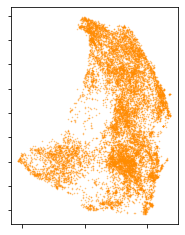

In [21]:
name_class = number_to_class[selected_class]
fname = "figures/Fig6_unsupervised_discovery_partialunsupembedding_{}".format(name_class)

fig = plot_embedding(reducer_embeddings, class_to_color[name_class], fname= fname, save = False)

## Features:

### 1-45: distance

### 46-90: angle

### 91-100: speed

### - distance:

1-9: snout_resident : neck_resident, hip1_resident, hip2_resident, tailbase_resident, snout_intruder, neck_intruder, hip1_intruder, hip2_intruder, tailbase_intruder

10-17: neck_resident : hip1_resident, hip2_resident, tailbase_resident, snout_intruder, neck_intruder, hip1_intruder, hip2_intruder, tailbase_intruder

18-24: hip1_resident : hip2_resident, tailbase_resident, snout_intruder, neck_intruder, hip1_intruder, hip2_intruder, tailbase_intruder

25-30: hip2_resident : tailbase_resident, snout_intruder, neck_intruder, hip1_intruder, hip2_intruder, tailbase_intruder

31-35: tailbase_resident : snout_intruder, neck_intruder, hip1_intruder, hip2_intruder, tailbase_intruder

36-39: snout_intruder : neck_intruder, hip1_intruder, hip2_intruder, tailbase_intruder

40-42: neck_intruder : hip1_intruder, hip2_intruder, tailbase_intruder

43-44: hip1_intruder : hip2_intruder, tailbase_intruder

45:  hip2_intruder  : tailbase_intruder'

### - same for angular change.

### - for speed:

it goes sequential, 91-95 is resident snout, neck, hip1, hip2, tailbase speed; whereas 96-100 is intruder snout, neck hip1, hip2, tailbase speed.

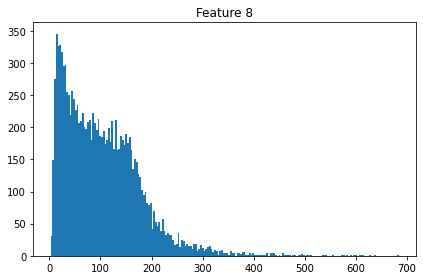

In [45]:
#explore unscaled features
#we are interested in a specific feature to capture our behavior subcomponent:

#If you want RESIDENT snout: INTRUDER tailbase
#it's scaled_features_train[:, 8]
#If you want INTRUDER snout: RESIDENT tailbase
#it's scaled_features_train[:, 30]

selected_features = [8] # res_snout to intr_tail_base distance

pseudo_labels = np.zeros(features_train_just_investigation.shape[0])

#pseudo_labels = np.random.randint(0, 3, size = scaled_features_train_just_other.shape[0])
if len(selected_features) > 1:
    fig, axs = plt.subplots(len(selected_features), 1, sharex=False)

    for num, feature_num in enumerate(selected_features):  
        axs[num].set_title(f"Feature {feature_num}")
        axs[num].hist(features_train_just_investigation[:, feature_num], bins = 100)

        
else:
    plt.figure()
    #go through one feature and select label based on threshold
    plt.title(f"Feature {selected_features[0]}")
    plt.hist(features_train_just_investigation[:, selected_features[0]], bins = 200)

plt.tight_layout()


#### Find those annotations of investigation, where the distance of this feature is below a threshold


(0.0, 120.0)

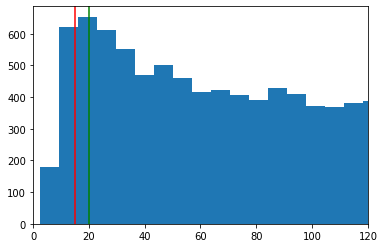

In [46]:
enter_radius = 15
exit_radius = 20

plt.figure()
plt.hist(features_train_just_investigation[:, selected_features[0]], bins = 100)
plt.axvline(enter_radius, color= 'r')
plt.axvline(exit_radius, color= 'g')
plt.xlim(0,exit_radius + 100)

In [47]:
# taken from dlstream analysis code for anogenital approach
#selected feature
dist = features_train_just_investigation[:, selected_features[0]]
#empty array
inside = np.zeros(dist.shape[0],dtype=bool)

# Check whether Resident starts in inner Radius
if dist[0] <= enter_radius:
    inside[0] = True
else:
    inside[0] = False

# Loop through all frames to check event status. Because of temporal dependencies this is not done as a check by numpy (eg. inside = dist <= enter_radius).
for i in range(1,dist.shape[0]):
    # If the Resident nose is inside the enter radius, no temporal checks are needed, the frame is counted as an event.
    if dist[i] <= enter_radius:
        inside[i] = True
    # If the Resident nose is not inside the enter radius but the exit radius, temporal cohesion is upheld
    elif dist[i] <= exit_radius:
        inside[i] = inside[i-1]
    # If the Resident nose is outside the exit radius, the frame is definitely not an event
    else:
        inside[i] = False

print(f"Number of labels: {inside.sum()}, total labels: {inside.shape[0]}")    

Number of labels: 841, total labels: 12300


In [48]:
def plot_threshold_embedding(plt_reducer_embeddings, threshold_bool, base_color, threshold_color, include_info = False, fname = None, save = False):
    
    v_alpha = 0.5
    
    fig = plt.figure(figsize=(3, 4))
    ax = fig.add_subplot()
    #all false values
    ax.scatter(plt_reducer_embeddings[~threshold_bool, 0], plt_reducer_embeddings[~threshold_bool, 1],
               s=0.3, c=base_color, alpha=v_alpha, label = "Rest")
    #all true values
    ax.scatter(plt_reducer_embeddings[threshold_bool, 0], plt_reducer_embeddings[threshold_bool, 1],
               s=0.3, alpha=v_alpha, c = threshold_color, label = "Selected")
    
    if include_info:
        ax.set_xlabel('UMAP Dim. 1', fontsize=12)
        ax.set_ylabel('UMAP Dim. 2', fontsize=12)
        ax.legend(markerscale=6, fontsize=12)
    else:
        ax.set_xticklabels('')
        ax.set_yticklabels('')
        
    if save and fname is not None:
        fig.savefig(fname +".png", dpi=600)
        fig.savefig(fname + ".svg", dpi=600)
   
    return fig

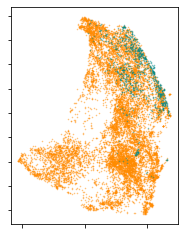

In [49]:
#save figure

fname = f"figures/Fig6_unsupervised_discovery_threshold_feat{selected_features[0]}_unsupervisedembedding_investigation"

fig = plot_threshold_embedding(reducer_embeddings, inside, class_to_color[name_class], extra_color_map[0], fname = fname, save = False)

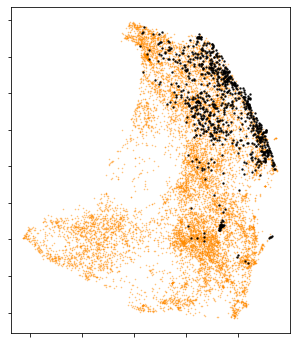

In [127]:
markersize = 2
v_alpha = 0.8
# v_alpha = 0.5

fig = plt.figure(figsize=(5, 6))
ax = fig.add_subplot()
#all false values
ax.scatter(reducer_embeddings[~inside, 0], reducer_embeddings[~inside, 1],
           s=0.3, c='darkorange', alpha=0.5, label = "Rest")
#all true values
ax.scatter(reducer_embeddings[inside, 0], reducer_embeddings[inside, 1],
           s=markersize, alpha=0.8, c = 'k', label = "Selected")

ax.set_xticklabels('')
ax.set_yticklabels('')
plt.show()

fig.savefig(r'H:\collabs\MABe\figures\tmp\investigate_threshold.png', dpi=600)
fig.savefig(r'H:\collabs\MABe\figures\tmp\investigate_threshold.svg', dpi=600)